\begin{center} 
Chun-Yuan (Scott) Chiu 
\end{center}
\begin{center} 
chunyuac@andrew.cmu.edu 
\end{center}

In [7]:
from adaboost_starter_code import *

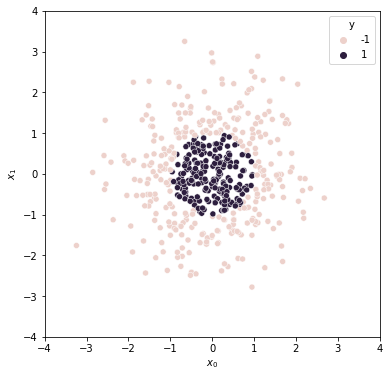

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
from pandas import DataFrame

X_train, y_train = get_circle_data(500)
data = DataFrame(X_train, columns=['$x_0$', '$x_1$'])
data['y'] = y_train

fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax = sns.scatterplot(x='$x_0$', y='$x_1$', hue='y', data=data)
ax.set(xlim=(-4, 4), ylim=(-4, 4))
plt.show()

/home/jovyan/mscf_hw_spring/ML II/1/adaboost_starter_code.py:54: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.axes()


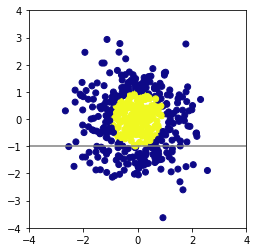

In [9]:
X_train, y_train = get_circle_data(500)
X_test, y_test = get_circle_data(500)

trees, alphas = my_adaboost(X_train, y_train, B=1)
draw_boosted_trees(trees, X_train, y_train)

/home/jovyan/mscf_hw_spring/ML II/1/adaboost_starter_code.py:54: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.axes()


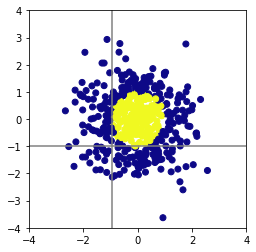

In [10]:
trees, alphas = my_adaboost(X_train, y_train, B=2)
draw_boosted_trees(trees, X_train, y_train)

/home/jovyan/mscf_hw_spring/ML II/1/adaboost_starter_code.py:54: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.axes()


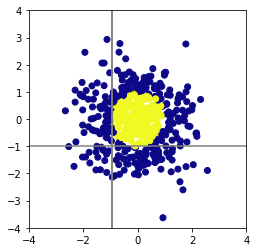

In [11]:
trees, alphas = my_adaboost(X_train, y_train, B=3)
draw_boosted_trees(trees, X_train, y_train)

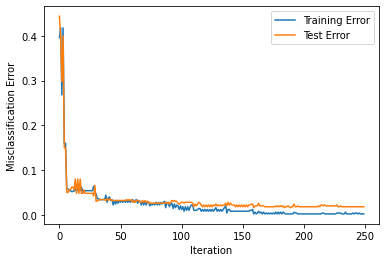

In [12]:
import matplotlib.pyplot as plt
from pandas import DataFrame

trees, alphas = my_adaboost(X_train, y_train, B=250)
err_train = predict_ada(trees, alphas, X_train, y_train)[-1]
err_test = predict_ada(trees, alphas, X_test, y_test)[-1]

pred_err = DataFrame({'Training Error': err_train, 'Test Error': err_test})
ax = pred_err.plot()
ax.set(ylabel='Misclassification Error', xlabel='Iteration')
plt.show()

/home/jovyan/mscf_hw_spring/ML II/1/adaboost_starter_code.py:54: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.axes()


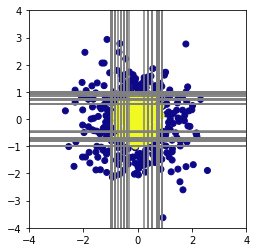

In [13]:
draw_boosted_trees(trees, X_train, y_train)

In [14]:
pred_err

,Training Error,Test Error
0,0.396,0.444
1,0.418,0.400
2,0.268,0.298
3,0.418,0.400
4,0.160,0.150
...,...,...
245,0.004,0.018
246,0.002,0.018
247,0.002,0.018
248,0.002,0.018


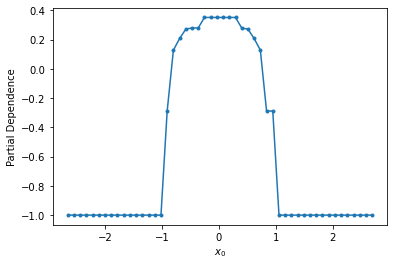

In [16]:
from pandas import DataFrame
import matplotlib.pyplot as plt
import numpy as np

np.random.seed(0)

X, y = get_circle_data(500)
trees, alphas = my_adaboost(X, y, B=250)
ax = DataFrame(np.array(calculate_partial_dependence_x1(trees, alphas, X)).T, columns=['$x_0$', 'Partial Dependence']).set_index('$x_0$').plot(style='.-', legend=None)
ax.set(ylabel='Partial Dependence')
plt.show()
